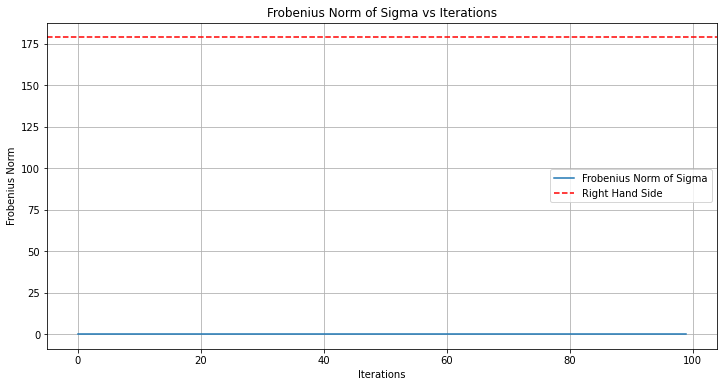

Final Frobenius norm of Sigma: 0.048865169286727905
Right hand side of the inequality: 178.88543819998318
The inequality is satisfied <


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子，保证实验结果可重复
torch.manual_seed(42)
np.random.seed(42)

# 定义一个简单的全连接神经网络模型
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 5)  # 输入维度为10，输出维度为5
        self.fc2 = nn.Linear(5, 1)   # 输入维度为5，输出维度为1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 计算 Sigma 矩阵的函数
def calculate_sigma(model, input_data, batch_size):
    # 将模型设为评估模式，这样在前向传播时不会应用 dropout 等技术
    model.eval()
    
    # 前向传播，获取输出
    with torch.no_grad():
        outputs = model(input_data)
    
    # 计算梯度
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            grad = param.grad.detach().numpy().flatten()
            grads.append(grad)
        else:
            grad = torch.zeros_like(param).detach().numpy().flatten()
            grads.append(grad)
    
    grads = np.concatenate(grads)
    Sigma = np.outer(grads, grads) / batch_size

    return Sigma

# 实例化模型
model = SimpleNet()

# 随机生成输入数据（batch_size = 32，输入维度为10）
batch_size = 32
input_data = torch.randn(batch_size, 10)

# 参数设置
delta = 0.1     # 给定的 delta 值
s = 0.01        # 学习率
iterations = 100  # 迭代次数

# 初始化空列表，用于存储每步的 Sigma 矩阵的 Frobenius 范数
sigma_f_norms = []

# 计算每步的 Sigma 矩阵并记录其 Frobenius 范数
for i in range(iterations):
    # 反向传播计算梯度
    model.zero_grad()
    output = model(input_data)
    loss = torch.mean(output)  # 假设这里的损失函数是输出的均值
    loss.backward()
    
    # 计算 Sigma 矩阵的 Frobenius 范数
    Sigma = calculate_sigma(model, input_data, batch_size)
    Sigma_F_norm = np.linalg.norm(Sigma, 'fro')
    sigma_f_norms.append(Sigma_F_norm)

# 计算不等式右侧的值
right_hand_side = np.sqrt(batch_size / delta / s)

# 绘制 Sigma 矩阵的 Frobenius 范数随迭代次数的变化图
plt.figure(figsize=(12, 6))
plt.plot(sigma_f_norms, label='Frobenius Norm of Sigma')
plt.axhline(y=right_hand_side, color='r', linestyle='--', label='Right Hand Side')
plt.xlabel('Iterations')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm of Sigma vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig("picture/inequalitHolds_sigmaFrobenius.png")
plt.show()

# 输出最后一步 Sigma 矩阵的 Frobenius 范数和右侧的值
print(f"Final Frobenius norm of Sigma: {sigma_f_norms[-1]}")
print(f"Right hand side of the inequality: {right_hand_side}")

# 比较左右两侧的值
if Sigma_F_norm == right_hand_side:
    print("The inequality is satisfied =")
elif Sigma_F_norm < right_hand_side:
    print("The inequality is satisfied <")
else:
    print("The inequality is not satisfied.")
